In [1]:
%pip install tf_keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import os
import json
import tensorflow as tf
import matplotlib.pyplot as plt
import math

import tf_keras as tfk
from tf_keras import layers, models
from tf_keras.losses import categorical_crossentropy, sparse_categorical_crossentropy
from sklearn.model_selection import train_test_split

print(f'Tensorflow V{tf.__version__}')
print(f'Keras V{tfk.__version__}')

2024-08-06 10:49:11.854847: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-06 10:49:11.854947: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-06 10:49:12.022365: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow V2.15.0
Keras V2.15.1


**Reference Notebook**: https://www.kaggle.com/code/markwijkhuizen/gislr-tf-data-processing-transformer-training/notebook

Based on Mark's notebook, I have learned a lot about analyzing and pre-processing data, as well as model implementation. However, there are some parts where I want to try out my own ideas. The data input and model implementation will be different from Mark's as well.

**v1**

Training model in 100 epochs with Learning Scheduler, the validation accuracy of model is 56%, which is a poor performance. 

**v2**

Add Z-score normalization for each frame: **part_landmark = (part_landmark - part_landmark_mean) / part_landmark_std**. The model has increased validation accuracy into 78% with loss 2.83. Testing in Test data returned 77% accuracy. The result overall is quite descent, but it is a great improvement compare to previous result.

# Data

In [3]:
# Dataset folder
data_path = "/kaggle/input/asl-signs"
df = pd.read_csv(os.path.join(data_path, "train.csv"))

# Check if there is any duplicate data
df.drop_duplicates()
display(df)

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie
...,...,...,...,...
94472,train_landmark_files/53618/999786174.parquet,53618,999786174,white
94473,train_landmark_files/26734/999799849.parquet,26734,999799849,have
94474,train_landmark_files/25571/999833418.parquet,25571,999833418,flower
94475,train_landmark_files/29302/999895257.parquet,29302,999895257,room


Base on `sign_to_prediction_index_map.json`, there are 250 signs in the dataset. So we want to check the distribution of every signs in the dataset


Highest frequency: 415
Lowest frequency: 299
Average frequency: 377.908



<Axes: ylabel='sign'>

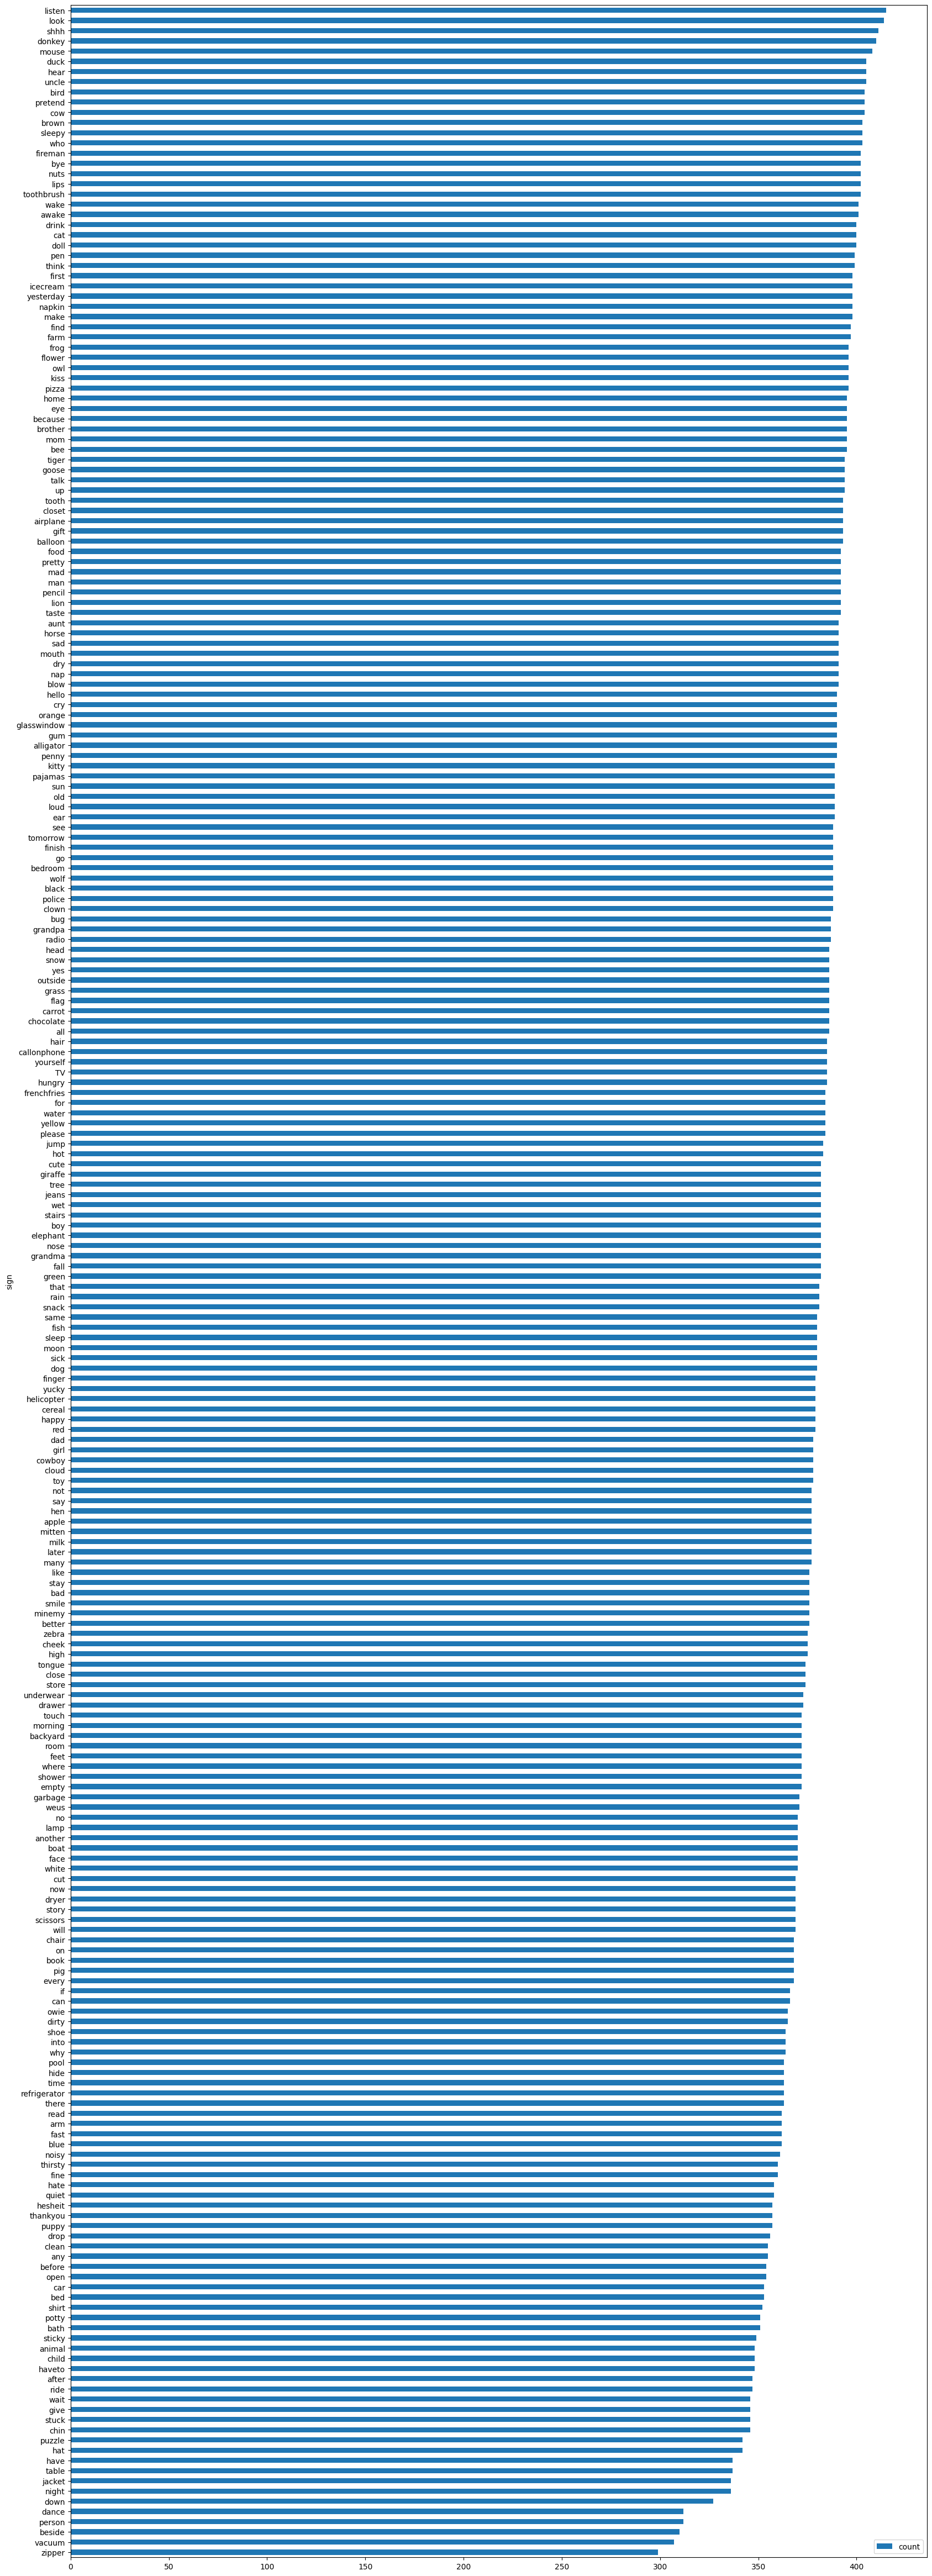

In [4]:
sign_distribution = df['sign'].value_counts().reset_index().sort_values('count')
print(f"\nHighest frequency: {sign_distribution['count'].max()}")
print(f"Lowest frequency: {sign_distribution['count'].min()}")
print(f"Average frequency: {sign_distribution['count'].mean()}\n")
sign_distribution.plot(kind='barh',x='sign', y='count', figsize=(20, 60))

From the graph, we can see that:
- The graph show a gradual descending of sign appearances
- The highest frequency sign is 'listen' with 415 appearances. While the lowest one is 'zipper' is 299 appearances.

As the difference between the highest and lowest frequency is 116, it is a balance dataset. However, we may consider increasing least frequency signs if the model had bad performance on those signs.

## Landmark Data

Base on dataset description: The landmarks were extracted from raw videos with the MediaPipe holistic model. Not all of the frames necessarily had visible hands or hands that could be detected by the model.

- `frame` - The frame number in the raw video.
- `row_id` - A unique identifier for the row.
- `type` - The type of landmark. One of ['face', 'left_hand', 'pose', 'right_hand'].
- `landmark_index` - The landmark index number.
- `[x/y/z]` - The normalized spatial coordinates of the landmark. These are the only columns that will be provided to your submitted model for inference. The MediaPipe model is not fully trained to predict depth so you may wish to ignore the z values.

There are 543 landmarks in total: 468 face landmarks, 21 landmarks for both left and right hand, 33 pose landmarks. As z values can be inaccurate and unnecessary, we will remove z-value to reduce model complexity.

In [5]:
# Take 16069/100015657.parquet as sample file
df_parq = pd.read_parquet(os.path.join(data_path, "train_landmark_files/16069/100015657.parquet"))
df_parq

,frame,row_id,type,landmark_index,x,y,z
0,103,103-face-0,face,0,0.437886,0.437599,-0.051134
1,103,103-face-1,face,1,0.443258,0.392901,-0.067054
2,103,103-face-2,face,2,0.443997,0.409998,-0.042990
3,103,103-face-3,face,3,0.435256,0.362771,-0.039492
4,103,103-face-4,face,4,0.443780,0.381762,-0.068013
...,...,...,...,...,...,...,...
57010,207,207-right_hand-16,right_hand,16,NaN,NaN,NaN
57011,207,207-right_hand-17,right_hand,17,NaN,NaN,NaN
57012,207,207-right_hand-18,right_hand,18,NaN,NaN,NaN
57013,207,207-right_hand-19,right_hand,19,NaN,NaN,NaN


Sign language relies on a combination of facial expressions, hand shapes, hand movements, and body posture to convey meaning. 

As our model replies on Mediapipe results, we need to make sure that the dataset has to be good enough to train model. 

There are 94477 files in total, so we will load 2000 files as sample data to analyze (sample size calculation with 99% confidence level)

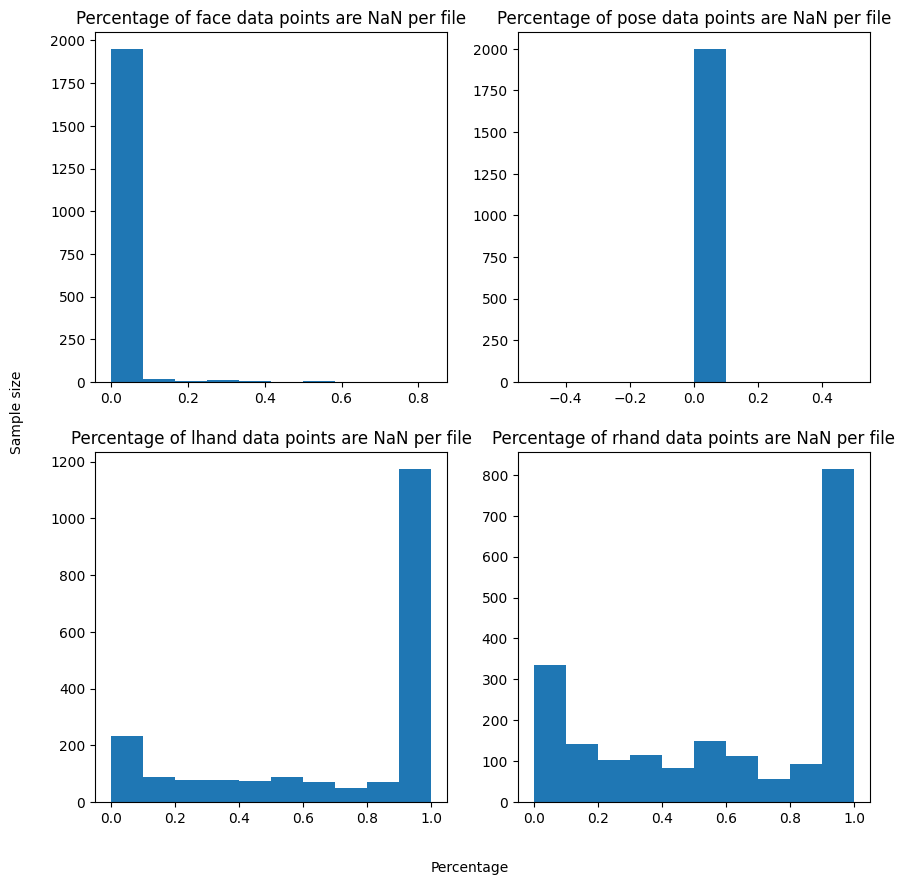

In [6]:
# Present "percentage of face, pose, left hand, right hand data point that are NaN per file"
def view_percentage_nan_datapoint(data_path, size=2000):
    LANDMARKS_PER_FRAME = 543
    df = pd.read_csv(os.path.join(data_path, "train.csv"))
    data_cols = ['x', 'y']
    
    face = []
    pose = []
    left_hand = []
    right_hand = []
    
    for i in range(size):
        pq = pd.read_parquet(os.path.join(data_path, df.iloc[i]["path"]), columns=data_cols).values
        face_nan_count, pose_nan_count, lhand_nan_count, rhand_nan_count = 0, 0, 0, 0
        
        frame_len = int(len(pq) / LANDMARKS_PER_FRAME)
        
        for j in range(frame_len):
            cur = j * LANDMARKS_PER_FRAME
            face_nan_count += (1 if np.isnan(pq[cur : cur + 468]).any() else 0)
            lhand_nan_count += (1 if np.isnan(pq[cur + 468: cur + 489]).any() else 0)
            pose_nan_count += (1 if np.isnan(pq[cur + 489 : cur + 511]).any() else 0)
            rhand_nan_count += (1 if np.isnan(pq[cur + 522 : cur + 543]).any() else 0)
        
        face.append(face_nan_count / frame_len)
        pose.append(pose_nan_count / frame_len)
        left_hand.append(lhand_nan_count / frame_len)
        right_hand.append(rhand_nan_count / frame_len)
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    fig.text(0.5, 0.04, 'Percentage', ha='center')
    fig.text(0.04, 0.5, 'Sample size', va='center', rotation='vertical')
    
    axs[0, 0].hist(face)
    axs[0, 1].hist(pose)
    axs[1, 0].hist(left_hand)
    axs[1, 1].hist(right_hand)
    
    axs[0, 0].title.set_text("Percentage of face data points are NaN per file")
    axs[0, 1].title.set_text("Percentage of pose data points are NaN per file")
    axs[1, 0].title.set_text("Percentage of lhand data points are NaN per file")
    axs[1, 1].title.set_text("Percentage of rhand data points are NaN per file")
    
view_percentage_nan_datapoint(data_path)

## Preprocess Data
Reference notebook: https://www.kaggle.com/code/markwijkhuizen/gislr-tf-data-processing-transformer-training/notebook

In sign language, it is not necessary to use both hands to sign. When a sign typically requires two hands, signers may use 'dominant hand' to execute the primary elements of the sign.

In [7]:
USE_TYPES = ['left_hand', 'pose', 'right_hand']

LANDMARKS_PER_FRAME = 543
INPUT_SIZE = 64

START_IDX = 468

LIP_IDXS0 = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])

LEFT_HAND_IDXS0 = np.arange(468,489)
RIGHT_HAND_IDXS0 = np.arange(522,543)

LEFT_POSE_IDXS0 = np.array([502, 504, 506, 508, 510])
RIGHT_POSE_IDXS0 = np.array([503, 505, 507, 509, 511])

LANDMARK_IDXS_LEFT_DOMINANT0 = np.concatenate((LIP_IDXS0, LEFT_HAND_IDXS0, LEFT_POSE_IDXS0))
LANDMARK_IDXS_RIGHT_DOMINANT0 = np.concatenate((LIP_IDXS0, RIGHT_HAND_IDXS0, RIGHT_POSE_IDXS0))

N_COLS = len(LANDMARK_IDXS_LEFT_DOMINANT0)
N_DIMS = 2

# Landmark indices after preprocess
LIP_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LIP_IDXS0)).squeeze()
HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_HAND_IDXS0)).squeeze()
POSE_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_POSE_IDXS0)).squeeze()

print(LIP_IDXS)
print(HAND_IDXS)
print(POSE_IDXS)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
[40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60]
[61 62 63 64 65]


In [8]:
def load_pq_data(pq_path):
    data_cols = ['x', 'y']
    # we only load x, y. 
    # At each frame, the order of landmarks will follow: 
    # 468 face landmarks, 21 left hand landmarks, 33 pose landmarks, 21 right hand landmark
    data = pd.read_parquet(pq_path, columns=data_cols)
    frame_len = int(len(data) / LANDMARKS_PER_FRAME)
    data = data.values.reshape(frame_len, LANDMARKS_PER_FRAME, 2)
    # Output shape: (frame_len, LANDMARKS_PER_FRAME, 2)
    
    return data.astype(np.float32)

In [9]:
class PreprocessLayer(layers.Layer):
    """
    Preprocess Layer: only using lips, hands, arm pose coordinates are used
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        normalisation_correction = np.array([
            # X coordinates
            [0] * len(LIP_IDXS) + [1] * len(HAND_IDXS) + [1] * len(POSE_IDXS),
            # Y coordinates
            [0] * len(LANDMARK_IDXS_LEFT_DOMINANT0)
        ], dtype=np.float32)
        # Normalisation_correction shape: (2, 66)
        self.normalisation_correction = tf.transpose(normalisation_correction, [1, 0])
        # Normalisation_correction shape: (66, 2)
        self.normalisation_correction = tf.expand_dims(self.normalisation_correction, axis=0)
        # Output shape: (1, 66, 2)
        
    
    def call(self, x):
        # Input shape: (frame_len, 543, 2)
        # Find dominant hand by comparing hand has less NaN value
        nan_lhand = tf.reduce_sum(tf.cast(tf.math.is_nan(tf.gather(x, LEFT_HAND_IDXS0, axis=1)), dtype=tf.int32))
        nan_rhand = tf.reduce_sum(tf.cast(tf.math.is_nan(tf.gather(x, RIGHT_HAND_IDXS0, axis=1)), dtype=tf.int32))
        
        DOMINANT_HAND_IDXS0 = LEFT_HAND_IDXS0 if nan_lhand <= nan_rhand else RIGHT_HAND_IDXS0
        
        # Get frame which dominant hand is non NaN
        frame_with_dominant_hand = tf.gather(x, DOMINANT_HAND_IDXS0, axis=1)
        # Output shape: (frame_len, len(DOMINANT_HAND_IDXS0), 2)
        
        # Get each nan value, replace it with 0, else replace with 1
        frame_with_dominant_hand = tf.where(tf.math.is_nan(frame_with_dominant_hand), 0, 1)
        # Output shape: (frame_len, len(DOMINANT_HAND_IDXS0), 2)
        
        frame_with_dominant_hand = tf.reduce_sum(frame_with_dominant_hand, axis=[1, 2])
        # Output shape: (frame_len,)
        
        # Get the indices of frame with dominant hand in x
        frame_with_dominant_hand_idxs = tf.where(frame_with_dominant_hand > 0)
        # Output shape: (new_frame_len, 1)
        
        frame_with_dominant_hand_idxs = tf.squeeze(frame_with_dominant_hand_idxs, axis=-1)
        # Output shape: (new_frame_len, )
        
        x1 = tf.gather(x, frame_with_dominant_hand_idxs, axis=0)
        # Output shape: (new_frame_len, 543, 2)
        
        # Gather dominant landmarks
        if nan_lhand <= nan_rhand:
            x1 = tf.gather(x1, LANDMARK_IDXS_LEFT_DOMINANT0, axis=1)
        else:
            x1 = tf.gather(x1, LANDMARK_IDXS_RIGHT_DOMINANT0, axis=1)
            # Convert right_hand into left_hand my multiply with -1 in x-axis and plus 1
            x1 = x1 * tf.where(self.normalisation_correction != 0, -1.0, 1.0) + self.normalisation_correction
        
        # Output shape: (new_frame_len, len(LANDMARK_IDXS_LEFT_DOMINANT)=66, 2)
        
        # Fill NaN value with 0
        x1 = tf.where(tf.math.is_nan(x1), 0.0, x1)
        # Padding video
        if x1.shape[0] < INPUT_SIZE:
            x1 = tf.pad(x1, [[0, INPUT_SIZE - x1.shape[0]], [0, 0], [0, 0]], constant_values=0)
        else:
            # Temp solution
            x1 = x1[:INPUT_SIZE, :, :]
            
        return x1, frame_with_dominant_hand_idxs
    
preprocess_layer = PreprocessLayer()

In [10]:
# Test preprocessing
t0 = load_pq_data(os.path.join(data_path, "train_landmark_files/16069/100015657.parquet"))
preprocess_layer(t0)

(<tf.Tensor: shape=(64, 66, 2), dtype=float32, numpy=
 array([[[0.38560516, 0.4665109 ],
         [0.38643575, 0.45775235],
         [0.39226276, 0.45012337],
         ...,
         [0.8058473 , 0.61530495],
         [0.75623685, 0.57142437],
         [0.7523265 , 0.5988766 ]],
 
        [[0.38012037, 0.46894348],
         [0.3815809 , 0.45983246],
         [0.38761443, 0.4522208 ],
         ...,
         [0.7714755 , 0.57653946],
         [0.7172193 , 0.53314847],
         [0.7200428 , 0.5672021 ]],
 
        [[0.38225058, 0.4676054 ],
         [0.38442922, 0.45791885],
         [0.39120498, 0.45031   ],
         ...,
         [0.7730696 , 0.577986  ],
         [0.7212551 , 0.53858864],
         [0.72741306, 0.5709294 ]],
 
        ...,
 
        [[0.        , 0.        ],
         [0.        , 0.        ],
         [0.        , 0.        ],
         ...,
         [0.        , 0.        ],
         [0.        , 0.        ],
         [0.        , 0.        ]],
 
        [[0.        , 0

## Create Dataset

In [11]:
def load_data(data_path, size):
    # Load csv file
    df = pd.read_csv(os.path.join(data_path, "train.csv"))
    X = []
    y = []
    # distribution of number of frames with non NaN dominant hand
    # in the data
    stat = []
    
    # Load json 
    with open(os.path.join(data_path, "sign_to_prediction_index_map.json")) as f:
        sign_map = json.load(f)
    
    size = len(df) if size == -1 else min(len(df), size)
    
    
    for i in range(size):
        print(f"\rLoad: {i + 1} files", end="")
        row = df.iloc[i]
        data = load_pq_data(os.path.join(data_path, row["path"]))
        # Pre-process data
        data, frame_with_dominant_hand_idxs = preprocess_layer(data)
        
        X.append(data)
        y.append(sign_map[row["sign"]])
        stat.append(len(frame_with_dominant_hand_idxs))
        
    X = np.array(X)
    # Output shape: (data_size, INPUT_SIZE, 66, 2)
    y = np.array(y)
    # Output shape: (data_size, )
    
    stat = np.array(stat)
    # Skip \r
    print()
    
    return X, y, stat

Load: 94477 files
Number of file with number of non empty hand frames less that 64: 87263


Text(0.5, 1.0, 'Distribution number of frames with dominant hand')

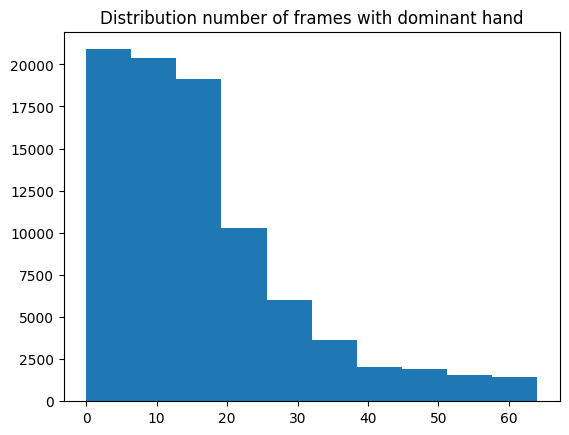

In [12]:
X, y, stat = load_data(data_path, -1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(f"Number of file with number of non empty hand frames less that {INPUT_SIZE}: {len(np.argwhere(stat <= 64))}")

plt.hist(stat, range=[0, 64])
plt.title("Distribution number of frames with dominant hand")

## Hand Landmarks X 


In [13]:
def view_hand_X():
    # Load x datapoint in hand landmark
    hand_landmarks = X_train[:, :, HAND_IDXS, 0]
    # Output shape: (data_size, INPUT_SIZE, 21)
    
    # Tranpose
    hand_landmarks = np.transpose(hand_landmarks, [2, 0, 1])
    hand_landmarks = np.reshape(hand_landmarks, (hand_landmarks.shape[0], -1))
    print(hand_landmarks)
    
    plt.boxplot(hand_landmarks)
    plt.show()

# view_hand_X()

# Transformer

In [14]:
NUM_CLASSES = 250

# Model config
LAYER_NORM_EPS = 1e-6

# Dense layer units for landmarks
LIPS_UNITS = 384
HANDS_UNITS = 384
POSE_UNITS = 384
# final embedding and transformer embedding size
UNITS = 512

# Transformer
NUM_BLOCKS = 2
MLP_RATIO = 2

# Dropout
EMBEDDING_DROPOUT = 0.00
MLP_DROPOUT_RATIO = 0.30
CLASSIFIER_DROPOUT_RATIO = 0.10

# Initiailizers
INIT_HE_UNIFORM = tfk.initializers.he_uniform
INIT_GLOROT_UNIFORM = tfk.initializers.glorot_uniform
INIT_ZEROS = tfk.initializers.constant(0.0)

GELU = tfk.activations.gelu

## Embedding

In [15]:
class LandmarkEmbedding(layers.Layer):
    def __init__(self, units, name):
        super().__init__(name=f'{name}_embedding')
        
        self.dense = models.Sequential([
            layers.Dense(UNITS, name=f'{name}_dense_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM),
            layers.Activation(GELU),
            layers.Dense(UNITS, name=f'{name}_dense_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM)
        ], name=f'{name}_dense')
        
    def call(self, x):
        # Input shape: (batch_size, INPUT_SIZE, -1)
        return self.dense(x)
        # Output shape: (batch_size, INPUT_SIZE, UNITS)

In [16]:
class Embedding(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
        # Embedding layer
        self.lip_embedding = LandmarkEmbedding(LIPS_UNITS, name='lips')
        self.hand_embedding = LandmarkEmbedding(HANDS_UNITS, name='hand')
        self.pose_embedding = LandmarkEmbedding(POSE_UNITS, name='pose')
        
        # Landmark Weights
        self.landmark_weights = tf.Variable(tf.zeros([3], dtype=tf.float32), name='landmark_weights')
        
        self.fc = models.Sequential([
            layers.Dense(UNITS, name='fc_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM),
            layers.Activation(GELU),
            layers.Dense(UNITS, name='fc_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM)
        ], name='fc')
        
        self.positional_encoding = tf.expand_dims(self.get_positional_encoding(INPUT_SIZE, UNITS), axis=0)
        # PE shape: (1, INPUT_SIZE, UNITS)
    
    # Using sinusoid positional encoding
    def get_positional_encoding(self, seq_len, d, n=10000):
        P = np.zeros((seq_len, d))
        for k in range(seq_len):
            for i in range(int(d / 2)):
                denominator = pow(n, 2 * i / d)
                P[k, 2 * i] = np.sin(k / denominator)
                P[k, 2 * i + 1] = np.cos(k / denominator)
        
        return tf.convert_to_tensor(P, dtype=tf.float32)
    
    def call(self, lip, hand, pose):
        lip_output = self.lip_embedding(lip)
        # Output shape: (batch_size, INPUT_SIZE, UNITS)
        
        hand_output = self.hand_embedding(hand)
        # Output shape: (batch_size, INPUT_SIZE, UNITS)
        
        pose_output = self.pose_embedding(pose)
        # Output shape: (batch_size, INPUT_SIZE, UNITS)
        
        # Stack to full landmark
        x = tf.stack((lip_output, hand_output, pose_output), axis=-1)
        # Output shape: (batch_size, INPUT_SIZE, UNITS, 3)
        
        x = x * tf.math.softmax(self.landmark_weights)
        x = tf.reduce_sum(x, axis=-1)
        # Output shape: (batch_size, INPUT_SIZE, UNITS)
        
        x = self.fc(x)
        # Output shape: (batch_size, INPUT_SIZE, UNITS)
        
        return x + self.positional_encoding

## Multi Head Attention

In [17]:
# scaled dot_product
def scaled_dot_product(queries, keys, values, mask=None):
    scores = tf.matmul(queries, keys, transpose_b=True) 
    scores /= tf.math.sqrt(tf.cast(queries.shape[-1], dtype=tf.float32))

    if mask is not None:
        scores += -1e9 * mask

    weights = tf.math.softmax(scores)

    return tf.matmul(weights, values)

In [18]:
class MultiHeadAttention(layers.Layer):
    def __init__(self, d_model, num_of_heads, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
        self.num_of_heads = num_of_heads
        
        self.depth = d_model // num_of_heads
        
        self.wq = [layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wk = [layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wv = [layers.Dense(self.depth) for i in range(num_of_heads)]
        
        self.wo = layers.Dense(d_model)
        
    def call(self,x, attention_mask):
        multi_attn = []
        
        for i in range(self.num_of_heads):
            Q = self.wq[i](x)
            K = self.wk[i](x)
            V = self.wv[i](x)
            multi_attn.append(scaled_dot_product(Q, K, V, attention_mask))
            
        multi_head = tf.concat(multi_attn,axis=-1)
        multi_head_attention = self.wo(multi_head)
        
        return multi_head_attention

## Model

In [19]:
class Transformer(models.Model):
    def __init__(self, num_blocks):
        super().__init__(name='transformer')
        self.num_blocks = num_blocks
    
    def build(self, input_shape):
        self.ln_1s = []
        self.mhas = []
        self.ln_2s = []
        self.mlps = []
        
        # Make Transformer Blocks
        for i in range(self.num_blocks):
            # Multi Head Attention
            self.mhas.append(MultiHeadAttention(UNITS, 8))
            
            # Multi Layer Perception
            self.mlps.append(models.Sequential([
                layers.Dense(UNITS * MLP_RATIO, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM),
                layers.Dropout(MLP_DROPOUT_RATIO),
                layers.Dense(UNITS, kernel_initializer=INIT_HE_UNIFORM),
            ]))
        
    def call(self, x, attention_mask):
        # Iterate input over transformer blocks
        for mha, mlp in zip(self.mhas, self.mlps):
            x = x + mha(x, attention_mask)
            x = x + mlp(x)
    
        return x

In [20]:
def scce_with_ls(y_true, y_pred):
    # One Hot Encode Sparsely Encoded Target Sign
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(y_true, NUM_CLASSES, axis=1)
    y_true = tf.squeeze(y_true, axis=2)
    # Categorical Crossentropy with native label smoothing support
    return categorical_crossentropy(y_true, y_pred, label_smoothing=0.25)

In [21]:
def get_model():
    landmark_input = layers.Input([INPUT_SIZE, N_COLS, N_DIMS], name='landmark_input')
    x = landmark_input
    # x shape: (batch_size, INPUT_SIZE, N_COLS=66, N_DIMS=2)
    
    # Create mask (1 as padding value, 0 for non-padding value)
    mask = tf.equal(x, 0)
    mask = tf.cast(tf.reduce_all(mask, axis=[2, 3]), tf.float32)
    # mask shape: (batch_size, INPUT_SIZE)
    
    temp_mask = tf.expand_dims(mask, axis=1)
    # mask1 shape: (batch_size, 1, INPUT_SIZE)
    
    mask = tf.expand_dims(mask, axis=-1)
    # mask shape: (batch_size, INPUT_SIZE, 1)
    
    attention_mask = tf.where(mask + temp_mask > 0, 1.0, 0.0)
    # attention_mask shape: (batch_size, INPUT_SIZE, INPUT_SIZE)
    
    
    ############################################
    # Get landmark parts
    
    ############################################
    # LIP
    lip_landmark = tf.slice(x, [0, 0, 0, 0], [-1, -1, 40, -1])
    # Output shape: (batch_size, INPUT_SIZE, 40, 2)
    
    lip_landmark_mean = tf.reduce_mean(lip_landmark, axis=2, keepdims=True)
    lip_landmark_std = tf.math.reduce_std(lip_landmark, axis=2, keepdims=True)
    # Lip landmark mean & std shape: (batch_size, INPUT_SIZE, 1, 2)
    
    
    # NOTE: When applying Z-score normalization in each frame, the standard deviation 
    # of padding value is 0, which divided by 0 will lead to NaN. So for every std value
    # we will replace it with 1
    lip_landmark_std = tf.where(lip_landmark_std == 0, 1.0, lip_landmark_std)
    
    lip_landmark = tf.reshape(
        (lip_landmark - lip_landmark_mean) / lip_landmark_std, 
        [-1, INPUT_SIZE, 40*2]
    )
    
    
    # Output shape: (batch_size, INPUT_SIZE, 80)
    
    
    ############################################
    # HAND
    hand_landmark = tf.slice(x, [0, 0, 40, 0], [-1, -1, 21, -1])
    # Output shape: (batch_size, INPUT_SIZE, 21, 2)
    
    hand_landmark_mean = tf.reduce_mean(hand_landmark, axis=2, keepdims=True)
    hand_landmark_std = tf.math.reduce_std(hand_landmark, axis=2, keepdims=True)
    # hand landmark mean & std shape: (batch_size, INPUT_SIZE, 1, 2)
    hand_landmark_std = tf.where(hand_landmark_std==0, 1.0, hand_landmark_std)
    
    hand_landmark = tf.reshape(
        (hand_landmark - hand_landmark_mean) / hand_landmark_std, 
        [-1, INPUT_SIZE, 21*2]
    )
    # Output shape: (batch_size, INPUT_SIZE, 42)
    
    
    ############################################
    # POSE
    pose_landmark = tf.slice(x, [0, 0, 61, 0], [-1, -1, 5, -1])
    # Output shape: (batch_size, INPUT_SIZE, 5, 2)
    
    pose_landmark_mean = tf.reduce_mean(pose_landmark, axis=2, keepdims=True)
    pose_landmark_std = tf.math.reduce_std(pose_landmark, axis=2, keepdims=True)
    # pose landmark mean & std shape: (batch_size, INPUT_SIZE, 1, 2)
    pose_landmark_std = tf.where(pose_landmark_std==0, 1.0, pose_landmark_std)
    
    pose_landmark = tf.reshape(
        (pose_landmark - pose_landmark_mean) / pose_landmark_std, 
        [-1, INPUT_SIZE, 5*2]
    )
    # Output shape: (batch_size, INPUT_SIZE, 10)

    ############################################
    
    x = Embedding()(lip_landmark, hand_landmark, pose_landmark)
    # Output shape: (batch_size, INPUT_SIZE, UNITS)
    
    x = Transformer(NUM_BLOCKS)(x, attention_mask)
    # Output shape: (batch_size, INPUT_SIZE, UNITS)
    
    # Pooling
    # Mark non-padding as 1 and padding value as zero
    mask = tf.where(mask==0, 1.0, 0.0)
    x = tf.reduce_sum(x * mask, axis=1) / tf.reduce_sum(mask, axis=1)
    
    # Classifier Dropout
    x = layers.Dropout(CLASSIFIER_DROPOUT_RATIO)(x)
    
    # Classification Layer
    outputs = layers.Dense(NUM_CLASSES, activation='softmax', kernel_initializer=INIT_GLOROT_UNIFORM)(x)
    
    # Create model
    model = models.Model(inputs=landmark_input, outputs=outputs)
    
    # Sparse Categorical Cross Entropy With Label Smoothing
    loss = scce_with_ls
    
    # Adam Optimizer with weight decay
    optimizer = tfk.optimizers.Adam(learning_rate=1e-3, weight_decay=1e-5, clipnorm=1.0)
    
    # TopK Metrics
    metrics = [
        tfk.metrics.SparseCategoricalAccuracy(name='acc'),
        tfk.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_acc'),
        tfk.metrics.SparseTopKCategoricalAccuracy(k=10, name='top_10_acc'),
    ]
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    return model
    

In [22]:
model = get_model()

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 landmark_input (InputLayer  [(None, 64, 66, 2)]          0         []                            
 )                                                                                                
                                                                                                  
 tf.slice (TFOpLambda)       (None, 64, 40, 2)            0         ['landmark_input[0][0]']      
                                                                                                  
 tf.slice_1 (TFOpLambda)     (None, 64, 21, 2)            0         ['landmark_input[0][0]']      
                                                                                                  
 tf.slice_2 (TFOpLambda)     (None, 64, 5, 2)             0         ['landmark_input[0][0]']  

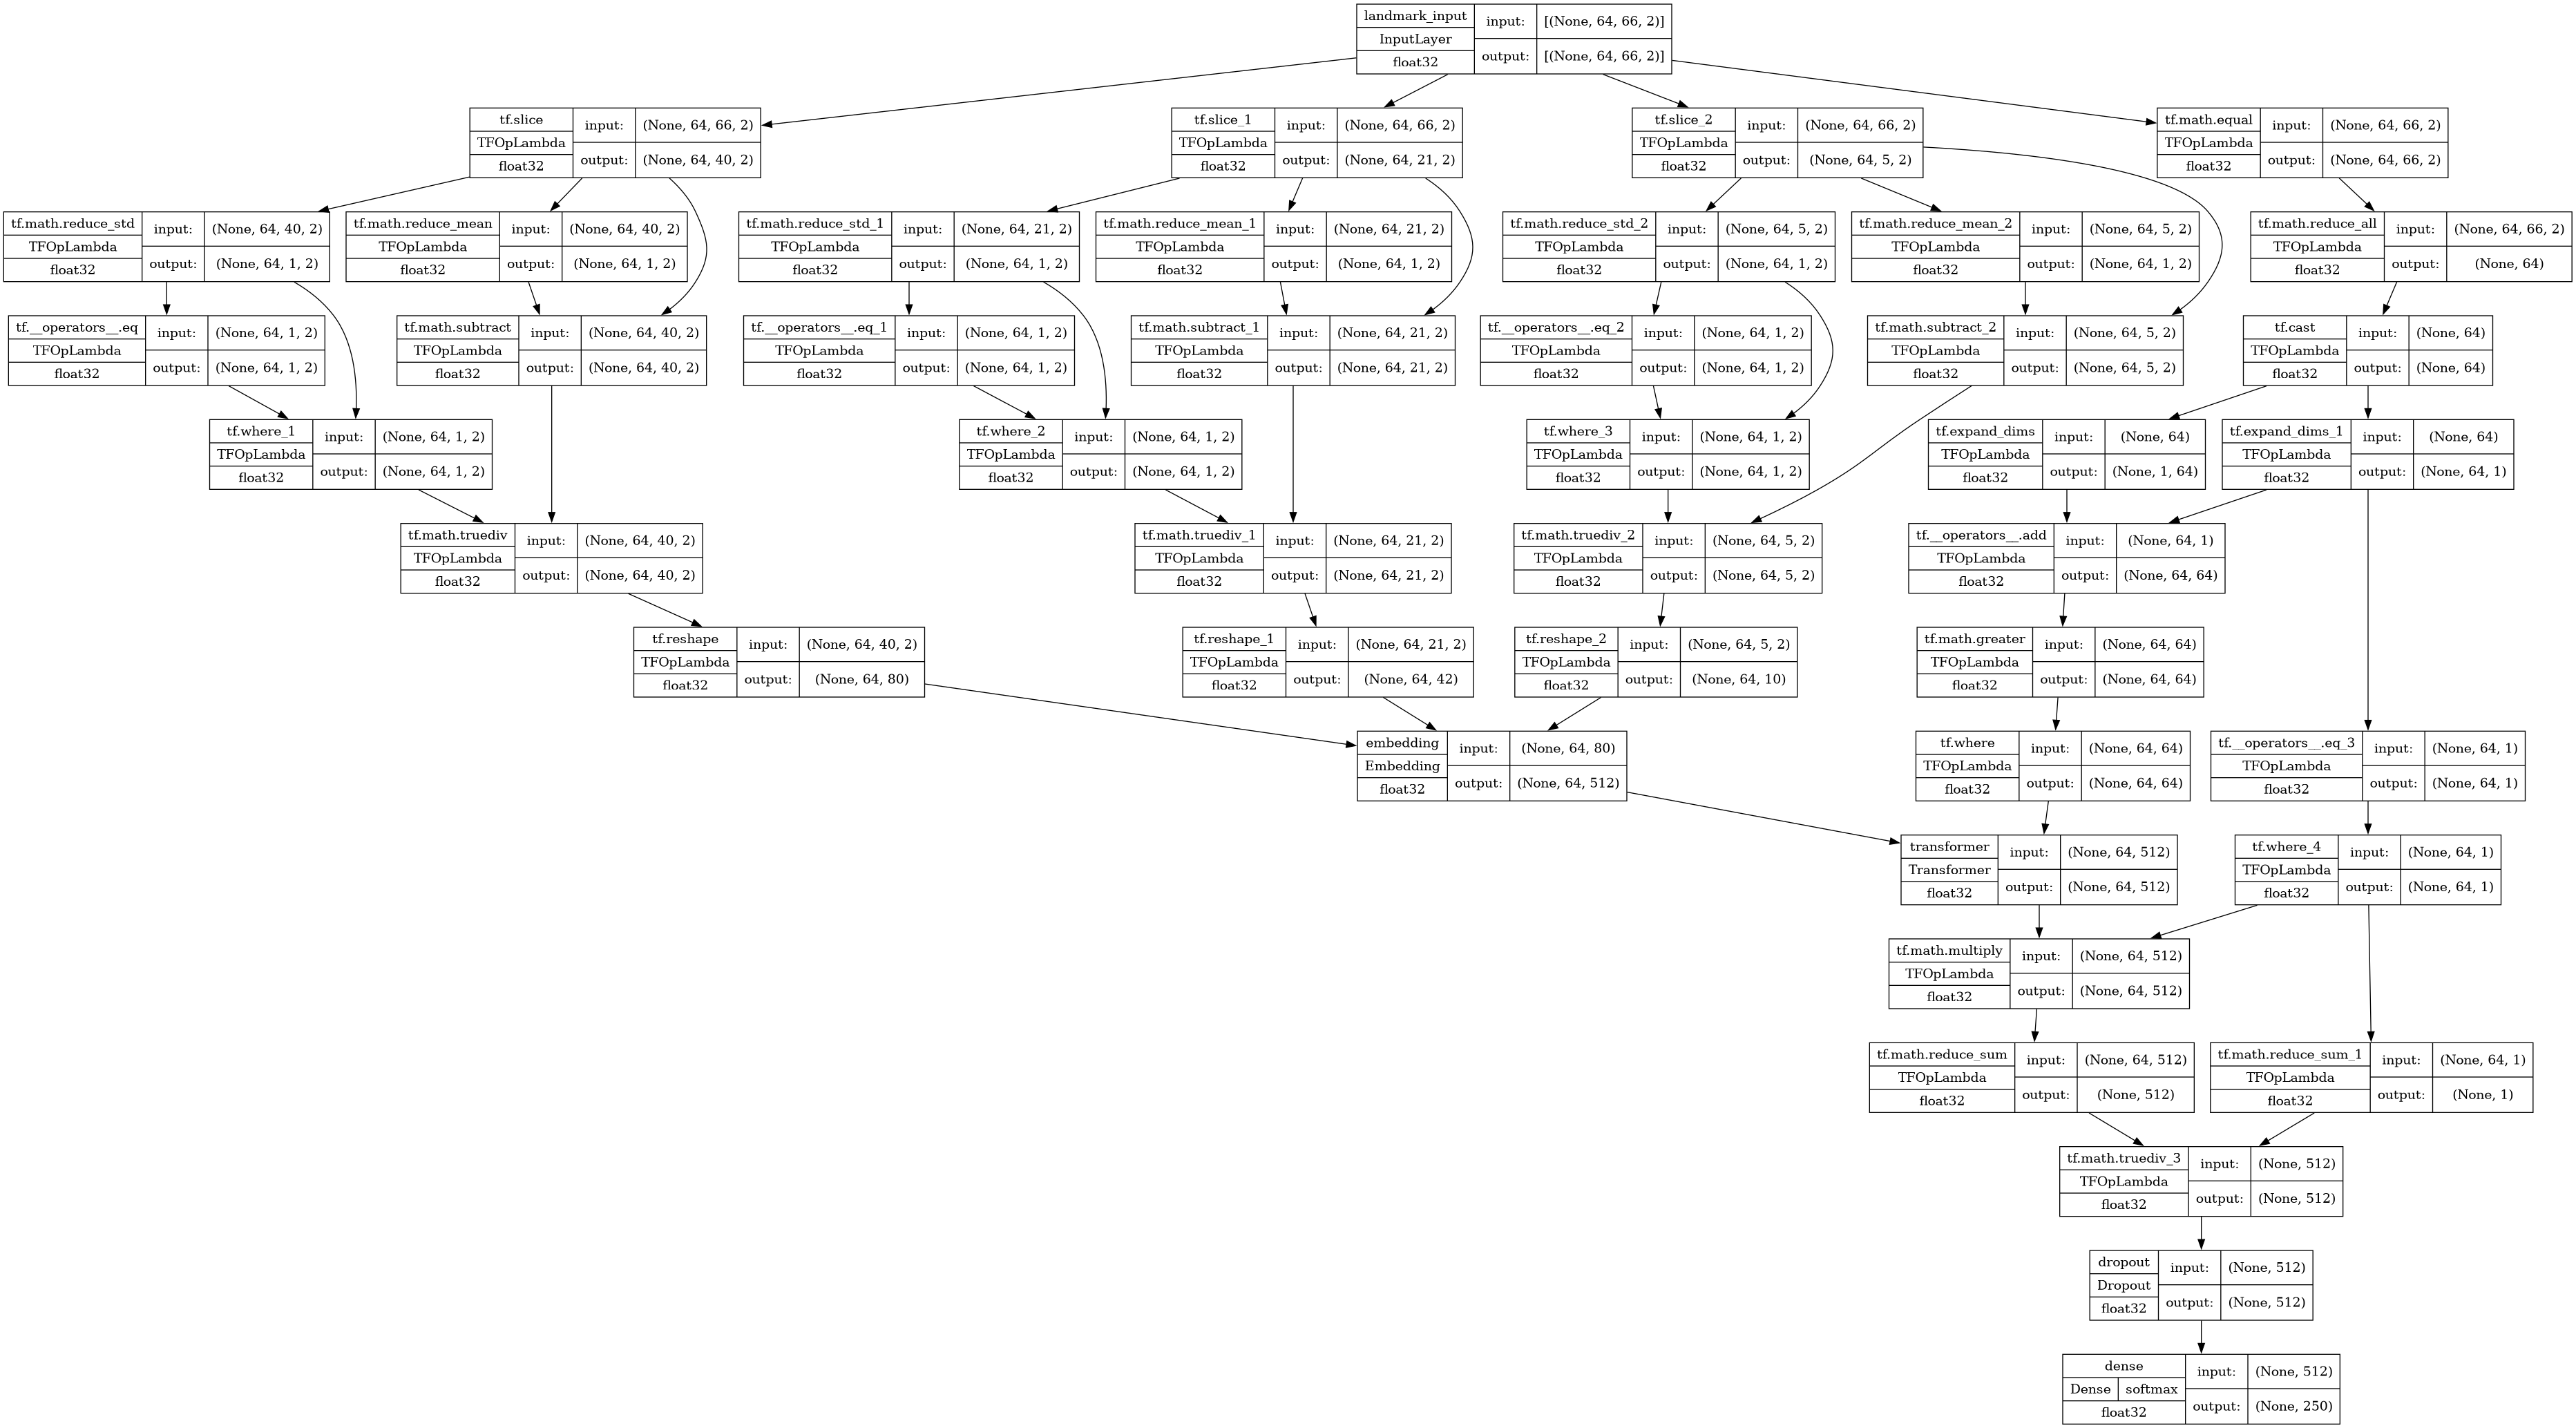

In [24]:
tfk.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=True, show_layer_activations=True)

In [25]:
# Training config

N_EPOCHS = 60

BATCH_ALL_SIGNS_N = 4
BATCH_SIZE = 256
LR_MAX = 1e-3
N_WARMUP_EPOCHS = 0
WD_RATIO = 0.05
MASK_VAL = 4237

## Learning Rate Scheduler

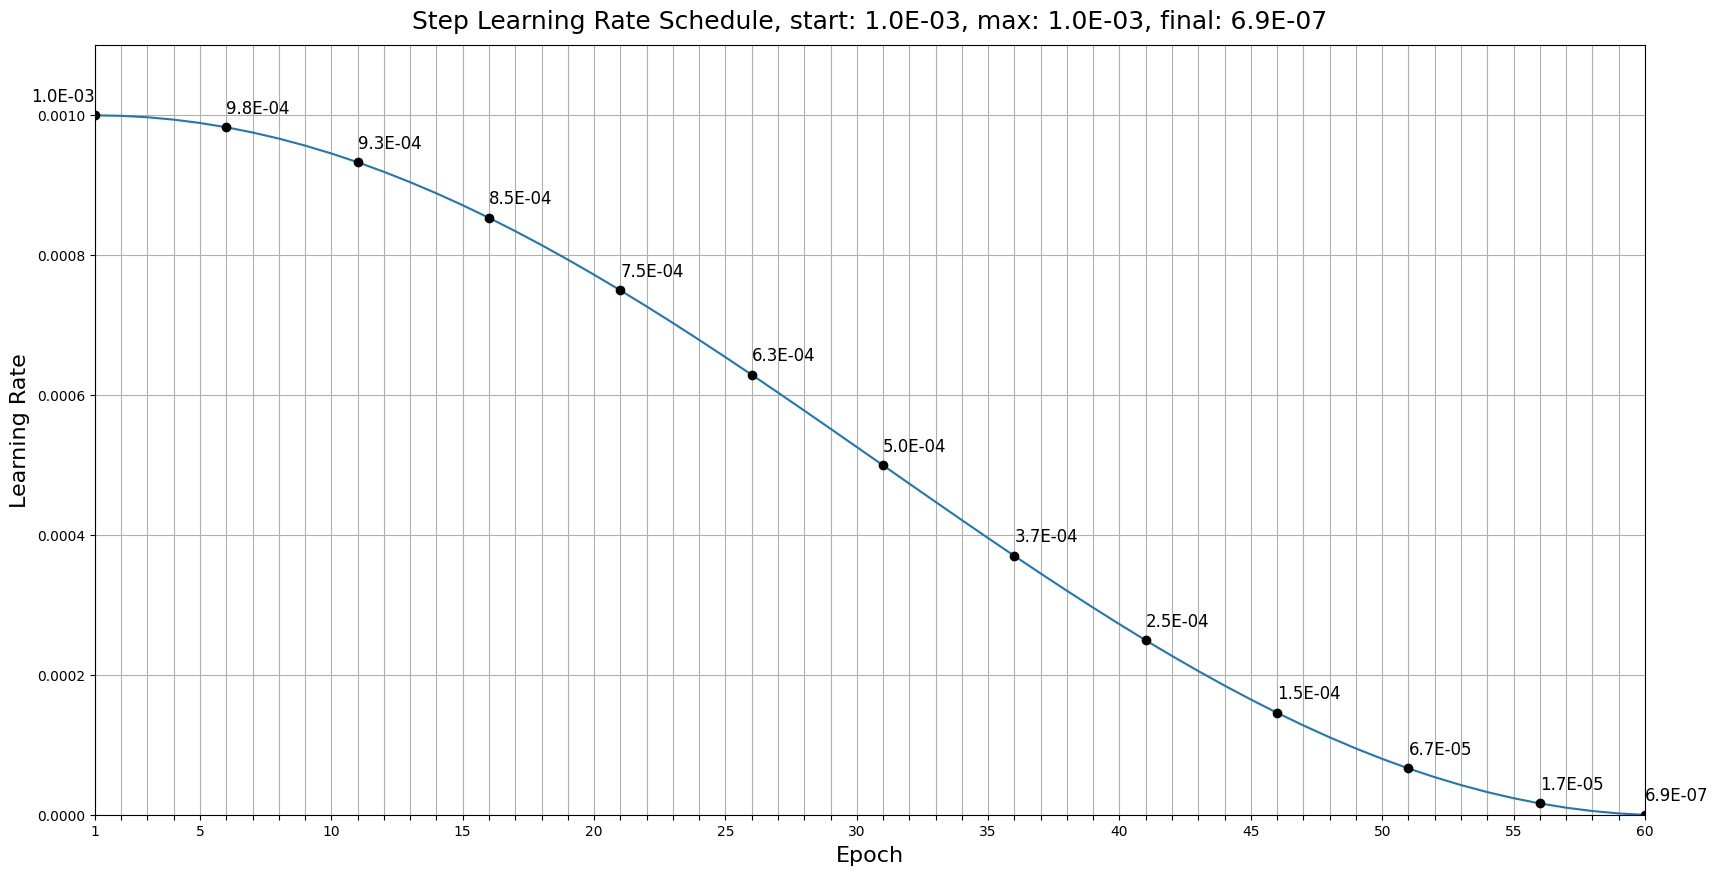

In [26]:
# Source: https://www.kaggle.com/code/markwijkhuizen/gislr-tf-data-processing-transformer-training/notebook
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):
    
    if current_step < num_warmup_steps:
        if WARMUP_METHOD == 'log':
            return lr_max * 0.10 ** (num_warmup_steps - current_step)
        else:
            return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max

def plot_lr_schedule(lr_schedule, epochs):
    fig = plt.figure(figsize=(20, 10))
    plt.plot([None] + lr_schedule + [None])
    # X Labels
    x = np.arange(1, epochs + 1)
    x_axis_labels = [i if epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, epochs + 1)]
    plt.xlim([1, epochs])
    plt.xticks(x, x_axis_labels) # set tick step to 1 and let x axis start at 1
    
    # Increase y-limit for better readability
    plt.ylim([0, max(lr_schedule) * 1.1])
    
    # Title
    schedule_info = f'start: {lr_schedule[0]:.1E}, max: {max(lr_schedule):.1E}, final: {lr_schedule[-1]:.1E}'
    plt.title(f'Step Learning Rate Schedule, {schedule_info}', size=18, pad=12)
    
    # Plot Learning Rates
    for x, val in enumerate(lr_schedule):
        if epochs <= 40 or x % 5 == 0 or x is epochs - 1:
            if x < len(lr_schedule) - 1:
                if lr_schedule[x - 1] < val:
                    ha = 'right'
                else:
                    ha = 'left'
            elif x == 0:
                ha = 'right'
            else:
                ha = 'left'
            plt.plot(x + 1, val, 'o', color='black');
            offset_y = (max(lr_schedule) - min(lr_schedule)) * 0.02
            plt.annotate(f'{val:.1E}', xy=(x + 1, val + offset_y), size=12, ha=ha)
    
    plt.xlabel('Epoch', size=16, labelpad=5)
    plt.ylabel('Learning Rate', size=16, labelpad=5)
    plt.grid()
    plt.show()

# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]
# Plot Learning Rate Schedule
plot_lr_schedule(LR_SCHEDULE, epochs=N_EPOCHS)
# Learning Rate Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=1)

## Weight Decay Callback

In [27]:
# Source: https://www.kaggle.com/code/markwijkhuizen/gislr-tf-data-processing-transformer-training/notebook
class WeightDecayCallback(tfk.callbacks.Callback):
    def __init__(self, wd_ratio=WD_RATIO):
        self.step_counter = 0
        self.wd_ratio = wd_ratio
    
    def on_epoch_begin(self, epoch, logs=None):
        model.optimizer.weight_decay = model.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {model.optimizer.learning_rate.numpy():.2e}, weight decay: {model.optimizer.weight_decay.numpy():.2e}')

# Train

In [28]:
# Clear all models in GPU
tfk.backend.clear_session()


# Actual Training
history = model.fit(
    X_train, y_train, 
    epochs=N_EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.2,
    callbacks = [
        lr_callback,
        WeightDecayCallback()
    ]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
learning rate: 1.00e-03, weight decay: 5.00e-05
Epoch 1/60


I0000 00:00:1722943416.159610      91 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


237/237 [==============================] - 116s 290ms/step - loss: 4.7392 - acc: 0.2506 - top_5_acc: 0.4941 - top_10_acc: 0.5970 - val_loss: 3.7495 - val_acc: 0.4158 - val_top_5_acc: 0.7107 - val_top_10_acc: 0.8049 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009993147673772868.
learning rate: 9.99e-04, weight decay: 5.00e-05
Epoch 2/60
237/237 [==============================] - 63s 264ms/step - loss: 3.5375 - acc: 0.4899 - top_5_acc: 0.7671 - top_10_acc: 0.8414 - val_loss: 3.4084 - val_acc: 0.5225 - val_top_5_acc: 0.7949 - val_top_10_acc: 0.8641 - lr: 9.9931e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009972609476841367.
learning rate: 9.97e-04, weight decay: 4.99e-05
Epoch 3/60
237/237 [==============================] - 62s 263ms/step - loss: 3.2623 - acc: 0.5809 - top_5_acc: 0.8311 - top_10_acc: 0.8875 - val_loss: 3.2903 - val_acc: 0.5643 - val_top_5_acc: 0.8223 - val_top_10_acc: 0.8787 - lr: 9.9726e-04

Epoch 4: LearningRateScheduler 

In [29]:
model.evaluate(X_test, y_test)

591/591 [==============================] - 11s 18ms/step - loss: 2.8433 - acc: 0.7674 - top_5_acc: 0.8946 - top_10_acc: 0.9174


[2.8432905673980713,
 0.7674111127853394,
 0.8946337699890137,
 0.9173899292945862]

## Training History

In [30]:
# Source: https://www.kaggle.com/code/markwijkhuizen/gislr-tf-data-processing-transformer-training/notebook
def plot_history_metric(metric, f_best=np.argmax, ylim=None, yscale=None, yticks=None):
    plt.figure(figsize=(20, 10))
    
    values = history.history[metric]
    N_EPOCHS = len(values)
    val = 'val' in ''.join(history.history.keys())
    # Epoch Ticks
    if N_EPOCHS <= 20:
        x = np.arange(1, N_EPOCHS + 1)
    else:
        x = [1, 5] + [10 + 5 * idx for idx in range((N_EPOCHS - 10) // 5 + 1)]

    x_ticks = np.arange(1, N_EPOCHS+1)

    # Validation
    if val:
        val_values = history.history[f'val_{metric}']
        val_argmin = f_best(val_values)
        plt.plot(x_ticks, val_values, label=f'val')

    # summarize history for accuracy
    plt.plot(x_ticks, values, label=f'train')
    argmin = f_best(values)
    plt.scatter(argmin + 1, values[argmin], color='red', s=75, marker='o', label=f'train_best')
    if val:
        plt.scatter(val_argmin + 1, val_values[val_argmin], color='purple', s=75, marker='o', label=f'val_best')

    plt.title(f'Model {metric}', fontsize=24, pad=10)
    plt.ylabel(metric, fontsize=20, labelpad=10)

    if ylim:
        plt.ylim(ylim)

    if yscale is not None:
        plt.yscale(yscale)
        
    if yticks is not None:
        plt.yticks(yticks, fontsize=16)

    plt.xlabel('epoch', fontsize=20, labelpad=10)        
    plt.tick_params(axis='x', labelsize=8)
    plt.xticks(x, fontsize=16) # set tick step to 1 and let x axis start at 1
    plt.yticks(fontsize=16)
    
    plt.legend(prop={'size': 10})
    plt.grid()
    plt.show()

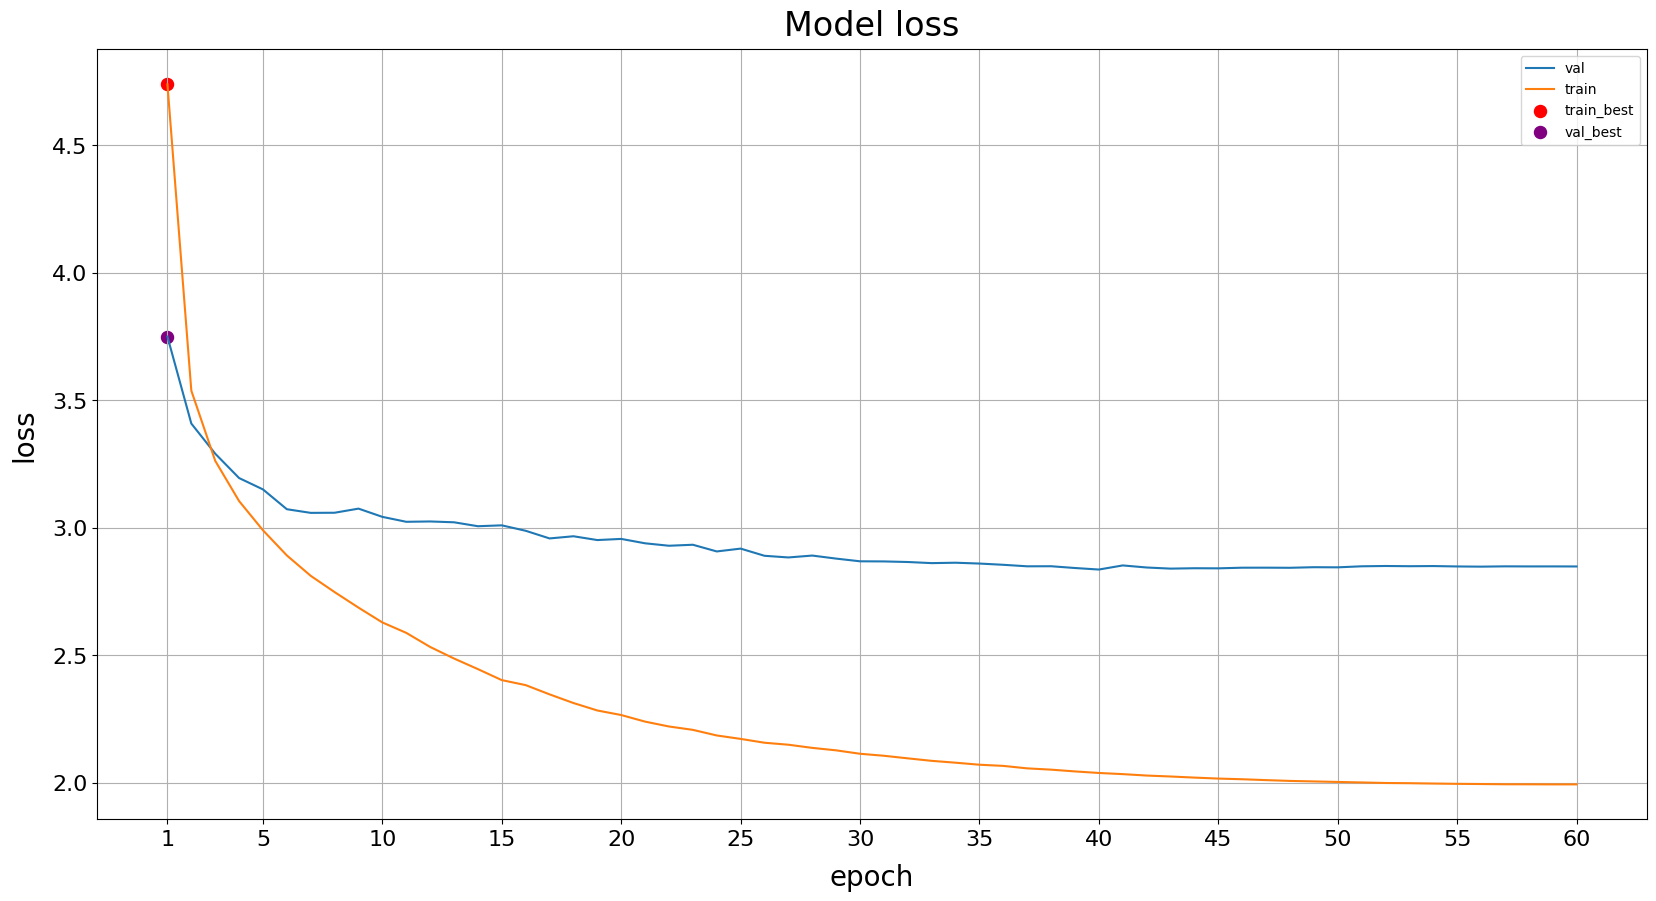

In [31]:
plot_history_metric('loss')

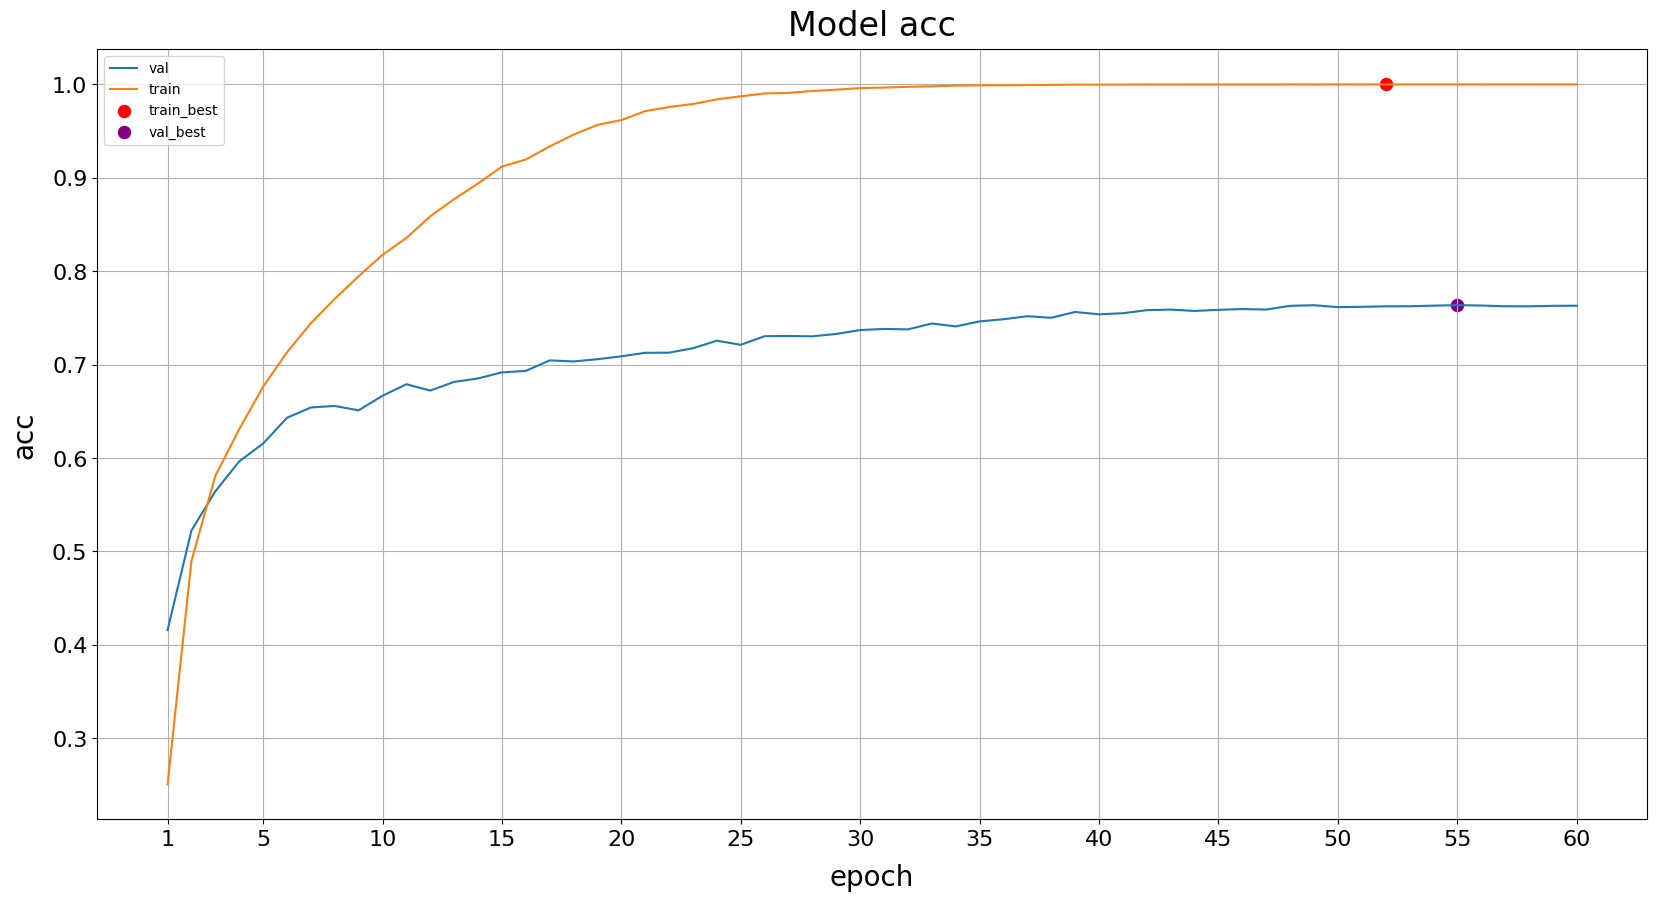

In [32]:
plot_history_metric('acc')

In [33]:
model.save('model_6_Aug.keras')